# Code Implementation & Technical Execution



Model Evaluation Metrics:

Accuracy: 0.85
Precision: 0.86
Recall: 0.85
F1 Score: 0.85

Classification Report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00         1
     neutral       0.62      0.71      0.67        21
    positive       0.92      0.88      0.90        78

    accuracy                           0.85       100
   macro avg       0.85      0.87      0.86       100
weighted avg       0.86      0.85      0.85       100



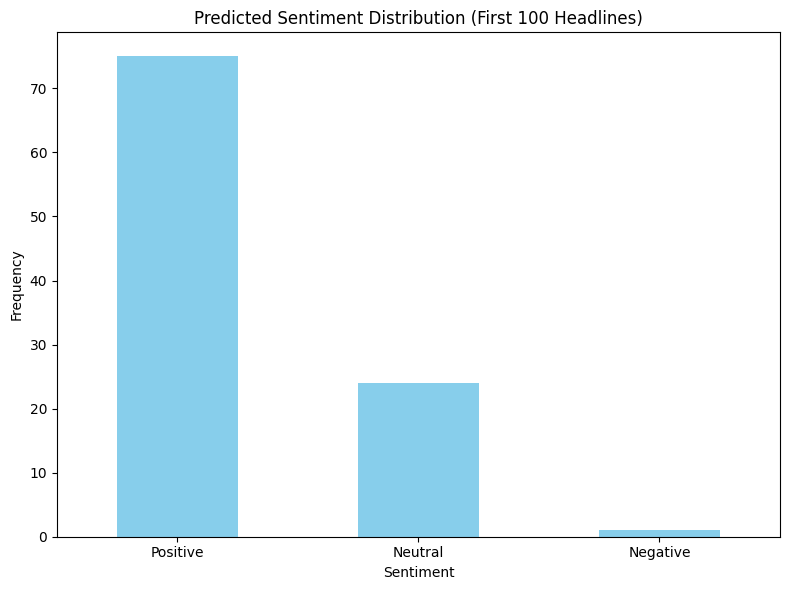

In [5]:
import os
import openai
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Retrieve the OpenAI API key from the environment variable.
# If not set, prompt the user to enter their API key.
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    api_key = input("Enter your OpenAI API Key: ")
openai.api_key = api_key

def preprocess_text(text):
    """
    Clean and standardize the input text.
    
    Parameters:
        text (str): The raw text string to be cleaned.
    
    Returns:
        str: The cleaned text string.
    """
    return text.strip()

def analyze_sentiment(text):
    """
    Analyze the sentiment of a given financial news headline using OpenAI's GPT-3.5 Turbo (O3 Mini High).
    
    Parameters:
        text (str): The cleaned financial news headline.
    
    Returns:
        str: The sentiment classification ('Positive', 'Negative', or 'Neutral').
    
    This function constructs a prompt for the GPT-3.5 Turbo model, sends it to the API,
    and extracts the first word of the response as the sentiment classification.
    If the response is unexpected, it defaults to 'Neutral'.
    """
    prompt = (
        f"Classify the sentiment of the following financial news headline as Positive, Negative, or Neutral.\n\n"
        f"Headline: \"{text}\"\n\nAnswer:"
    )
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-0125",  # Using O3 Mini High model
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,             # Deterministic output
            max_tokens=10                # Limit response length
        )
        result = response['choices'][0]['message']['content'].strip()
        # Extract the sentiment keyword from the result
        sentiment = result.split()[0].capitalize()
        if sentiment not in ["Positive", "Negative", "Neutral"]:
            sentiment = "Neutral"  # Fallback for unexpected responses
        return sentiment
    except Exception as e:
        print(f"API error for input: {text}\nError: {e}")
        return "Neutral"

def main():
    """
    Main function to execute the financial sentiment analysis pipeline.
    
    Steps:
    1. Load the dataset from a CSV file (first 100 rows) using latin1 encoding.
    2. Assign custom column names (assuming no header).
    3. Preprocess financial news headlines.
    4. Classify sentiment using the GPT-3.5 Turbo (O3 Mini High) API.
    5. Evaluate the model using accuracy, precision, recall, F1 score, and a classification report.
    6. Visualize the distribution of predicted sentiments.
    
    The dataset is expected to have at least two columns:
        - Column 0: Ground truth sentiment labels.
        - Column 1: Financial news headlines.
    """
    # Specify the path to your CSV file
    csv_path = r"C:\Users\ASUS\OneDrive\Desktop\PROMPT ENG\all-data.csv"

    try:
        # Load the first 100 rows of the CSV file using latin1 encoding to handle non-UTF8 characters
        df = pd.read_csv(csv_path, nrows=100, encoding='latin1', header=None)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    # Assign column names (expecting at least two columns)
    if df.shape[1] >= 2:
        df.columns = ['label', 'headline']
    else:
        print("Expected at least two columns: [label, headline]")
        return

    # Preprocess the headlines by removing extra whitespace
    df["cleaned_headline"] = df["headline"].apply(preprocess_text)

    # Analyze sentiment for each headline using GPT-3.5 Turbo (O3 Mini High)
    predictions = []
    for index, row in df.iterrows():
        sentiment = analyze_sentiment(row["cleaned_headline"])
        predictions.append(sentiment)
        time.sleep(1)  # Pause to respect API rate limits

    df["predicted_sentiment"] = predictions

    # Normalize ground truth and predictions to lowercase for fair evaluation
    y_true = df['label'].str.lower()
    y_pred = [pred.lower() for pred in predictions]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    class_report = classification_report(y_true, y_pred, zero_division=0)

    # Print evaluation metrics
    print("Model Evaluation Metrics:\n")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}\n")
    print("Classification Report:\n", class_report)

    # Visualize the distribution of predicted sentiments using a bar chart
    sentiment_counts = df["predicted_sentiment"].value_counts()
    plt.figure(figsize=(8, 6))
    sentiment_counts.plot(kind='bar', color='skyblue')
    plt.title("Predicted Sentiment Distribution (First 100 Headlines)")
    plt.xlabel("Sentiment")
    plt.ylabel("Frequency")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
